# CPSC 330 Lecture 16

Outline:

- 👋
- **Turn on recording**
- Announcements
- True/False questions from last time (10 min)
- Outliers: intro (10 min)
- Outlier scavenger hunt (20 min)
- Break (5 min)
- Mean vs median (5 min)
- Effect on trained models (15 min)
- Robust linear regression (10 min)
- Outlier scenarios (5 min)
- Summary

Piazza:

- True/False questions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest

In [3]:
plt.style.use("seaborn")
plt.rcParams['font.size'] = 16

In [4]:
from pandas_profiling import ProfileReport

## Announcements

- First 9 minutes of Lecture 15 recording were corrupted.
- hw6 released, due next Monday at 11:59pm.
- Golden Rule violation in Lecture 13 - see https://piazza.com/class/kb2e6nwu3uj23?cid=440.
- Midterm grades posted - see https://piazza.com/class/kb2e6nwu3uj23?cid=447.
- This lecture should be moved to the "first half" of the course.
- Next week we'll be talking about data involving time.
- You have 3 assignments left
  1. Time series
  2. Open-ended analysis on the dataset of your choosing
  3. Blog post about your analysis


## Outliers intro (10 min)

#### What is an outlier?


- Loosely speaking, an **outlier** is an observation that is very different from the others.
- These are also called **anomalies** is certain contexts.
- Let's take a look at these [CPSC 340 slides on outlier detection](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L10.pdf), section on "Global vs. Local Outliers".
- Keep in mind that we can have outliers in our features or in our targets (at least for regresson).

#### Why do we want to find outliers? 

Some main reasons are:

1. Data quality concerns. We want to **remove** the outliers.
2. Our task is actually to **find** (identify, detect) the outliers. E.g. credit card fraud.

Thus, outliers are not categorically good nor bad - it depends on the context.

#### How can we find outliers? Very high level overview.

- Most of outlier detection is unsupervised.
  - There are various approaches, today we'll consider looking at plots and summary statistics.
- But, remember our credit card fraud dataset? That was really supervised anomaly detection!
  - Find the unusual events (frauds) based on labelled data. 
  - Here, we could just use our regular supervised learning techniques.
  
Note: you can have both supervised and unsupervised cases where you want to find anomalies.

#### How can we guard against unwanted outliers?

There are two general strategies:

1. Remove outliers.
2. Use methods that are **robust** to outliers.

## Outlier scavenger hunt (15 min)

#### Census data (lectures 6-7)

In [5]:
df_census = pd.read_csv('data/adult.csv')
census_train, census_test = train_test_split(df_census, test_size=0.2, random_state=123)
census_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
17064,20,Private,110998,Some-college,10,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Female,0,0,30,United-States,<=50K
18434,22,Private,263670,HS-grad,9,Never-married,Other-service,Own-child,Black,Male,0,0,80,United-States,<=50K
3294,51,Private,335997,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,4386,0,55,United-States,>50K
31317,53,Private,111939,Bachelors,13,Married-civ-spouse,Other-service,Husband,White,Male,0,0,35,United-States,<=50K
4770,52,Self-emp-inc,51048,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States,<=50K


In [6]:
census_train.shape

(26048, 15)

In [7]:
profile_census = ProfileReport(census_train, minimal=True)

In [8]:
profile_census.to_notebook_iframe()

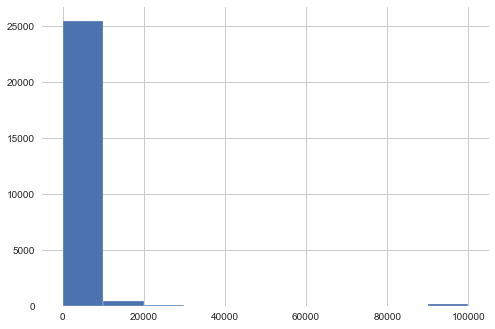

In [9]:
census_train["capital.gain"].hist();

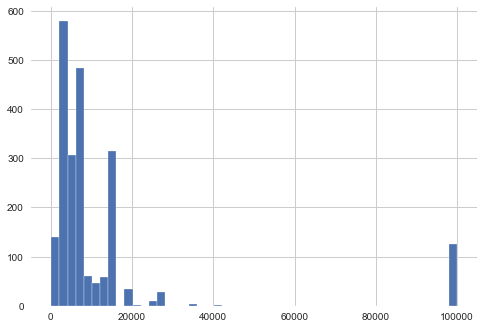

In [10]:
capital_gain = census_train["capital.gain"]
capital_gain[capital_gain > 0].hist(bins=50);

- It looks like we have a small number of individuals with a lot more capital gain than everyone else.
- Could those be outliers?

#### Isolation forests

- Another approach I heard about is isolation forests, conveniently built in to sklearn
  - Here is the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
  - It is kind of like a decision tree / random forest but it makes totally random splits
  - If it takes few splits to isolate an example, then it's more anomalous 
- We just need to do the feature preprocessing to get this to work:

In [11]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 
                    'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 
                        'relationship', 'race', 'sex', 'native.country']
target_column = 'income'
pipe_cat = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
census_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', pipe_cat, categorical_features)
])
census_preprocessor.fit(census_train);

In [12]:
census_columns = numeric_features + list(census_preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names(categorical_features))
census_train_enc = pd.DataFrame(census_preprocessor.transform(census_train), index=census_train.index, columns=census_columns)

In [13]:
isolation = IsolationForest()
predicted_outliers = isolation.fit_predict(census_train_enc) < 0

Above: from the documentation, `predict` returns +1 for inlier and -1 for outlier.

In [14]:
census_train_enc[predicted_outliers].head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
8741,0.911476,-0.217561,1.138922,-0.146669,-0.216807,-0.440078,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11042,-0.263361,-1.607267,-0.027403,-0.146669,-0.216807,-0.035091,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32245,-1.144488,-0.254085,1.138922,-0.146669,-0.216807,-0.440078,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5350,1.792603,5.777232,-3.137604,-0.146669,-0.216807,-0.845065,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29799,0.250630,1.194488,-0.416178,-0.146669,-0.216807,-0.035091,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- It found 61 outliers out of around 26,000 training examples.
- We can look at the capital gain of these cases for example:

In [15]:
census_train[predicted_outliers].head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
8741,51,Self-emp-inc,166386,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,35,Taiwan,<=50K
11042,35,Federal-gov,20469,Some-college,10,Divorced,Exec-managerial,Unmarried,Asian-Pac-Islander,Female,0,0,40,Philippines,<=50K
32245,23,Local-gov,162551,Bachelors,13,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,Female,0,0,35,China,<=50K
5350,63,Self-emp-not-inc,795830,1st-4th,2,Widowed,Other-service,Unmarried,White,Female,0,0,30,El-Salvador,<=50K
29799,42,Private,314649,HS-grad,9,Married-spouse-absent,Handlers-cleaners,Other-relative,Asian-Pac-Islander,Male,0,0,40,?,<=50K


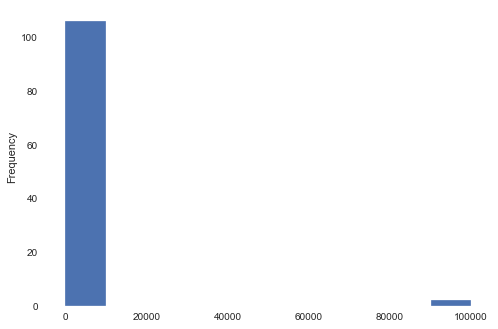

In [16]:
census_train.loc[predicted_outliers, "capital.gain"].plot.hist();

- We see lots of small (typical) values - it's not picking only based on capital gain here, but based on all the features.

#### Movie review data (lectures 4-5)

In [17]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_train, imdb_test = train_test_split(imdb_df, random_state=123)
imdb_train.head()

,type,review,label,file
31450,train,I don't know what that other guy was thinking....,neg,4556_2.txt
42809,train,Scott Henderson (Alan Curtis) is unjustly accu...,pos,3529_9.txt
52419,train,This film is by far one of my favorites. I saw...,unsup,12178_0.txt
45663,train,This is one horror movie based TV show that ge...,pos,6098_10.txt
50696,train,Wonderful film that sadly was not released in ...,unsup,10627_0.txt


Let's look at a histogram of the lengths of reviews:

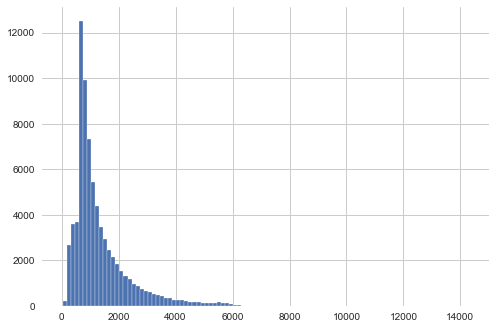

In [18]:
imdb_train["review"].apply(len).hist(bins=100);

In [19]:
imdb_train["review"].apply(len).max()

14282

Wow, that is a long review!

In [20]:
ind = imdb_train["review"].apply(len).argmax()
ind

28943

In [21]:
imdb_train["review"].iloc[ind]

'***SPOILERS*** ***SPOILERS*** The first Godzilla movie in the third movie series, whereas GODZILLA VS. DESTOROYAH, the previous entry, aptly ended the second series. What else can I say? Well, let\'s break it down.<br /><br />I once liked the 2nd series of Godzilla movies (1984-1995), even though I found something annoying about those movies (as either the bad or good guy, Godzilla was so sympathetic that the human characters came off as obnoxious). Then, in 1995, along came a movie called GAMERA: GUARDIAN OF THE UNIVERSE and its two successful sequels, all directed by master filmmaker Shuusuke Kaneko, who singlehandedly changed the face of Japanese monster movies forever. I was spoiled!!! The Series 2 Godzilla movies were suddenly looked down as half-hearted, heavy-handed, auto-piloted and lazy attempts at recreating the "original" Godzilla, and end up being an insult to the memory of genre masters Ishirou Honda and Eiji Tsuburaya. GAMERA 3: THE AWAKENING OF IRIS, released the same y

#### Amazon product ratings data (lecture 14)

In [22]:
df_ratings = pd.read_csv("data/ratings_Patio_Lawn_and_Garden.csv", names=("user","item","rating","timestamp"))
df_ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


Probably no outliers here, since ratings are from 1 to 5. But we might have "outlier" products or users in the sense of having given/received way more ratings than typical (see Lecture 14).

#### House price data (lecture 10-11)

In [23]:
housing_df = pd.read_csv("data/housing.csv")
housing_train, housing_test = train_test_split(housing_df, random_state=123)
housing_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1446,1447,20,RL,NaN,26142,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,157900
1123,1124,20,RL,50.0,9405,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,118000
186,187,80,RL,NaN,9947,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2009,WD,Normal,173000
1020,1021,20,RL,60.0,7024,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,176000
67,68,20,RL,72.0,10665,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,226000


In [24]:
housing_train.shape

(1095, 81)

In [25]:
profile_housing = ProfileReport(housing_train)

In [26]:
profile_housing.to_notebook_iframe()

(Small aside: check out the dendrogram of missing values - we just talked about dendrograms!)

Based on the above, let's look closer at `LotArea`:

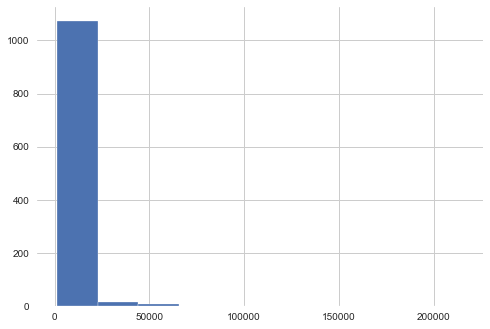

In [27]:
housing_train["LotArea"].hist();

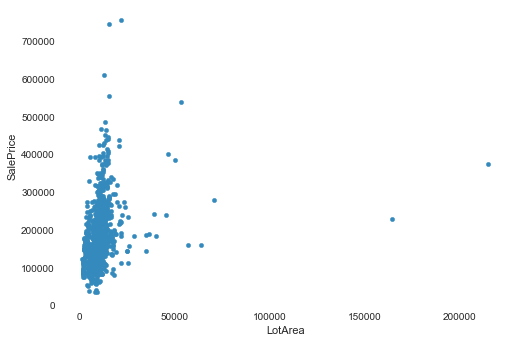

In [28]:
housing_train.plot.scatter(x="LotArea", y="SalePrice");

- Ok, it looks like we have some outliers on our hands!
- Are these outliers a problem?
- Let's look at the scaled version of `LotArea`:

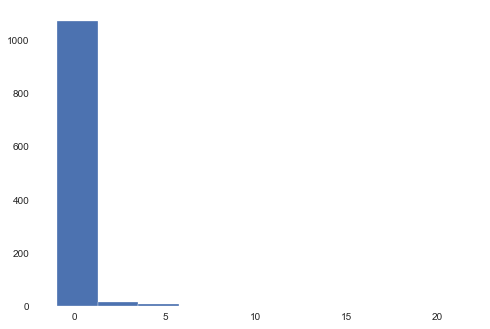

In [29]:
sc = StandardScaler()

area_transformed = sc.fit_transform(housing_train[["LotArea"]])
plt.hist(area_transformed);

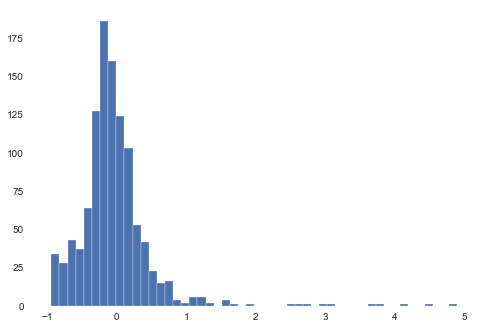

In [30]:
plt.hist(area_transformed[area_transformed < 5], bins=50);

What's happening here is that most of the points are between $-1$ and $1$, but then we have those outliers that are around 20:

In [31]:
area_transformed.max()

21.401850034926778

That is, 20 standard deviations above the mean!

In [32]:
sc.mean_

array([10299.34703196])

In [33]:
np.sqrt(sc.var_)

array([9576.07181779])

Question: what would these values have been without the outliers?

In [34]:
housing_train["LotArea"].mean()

10299.34703196347

In [35]:
housing_train["LotArea"].std()

9580.447450560465

In [36]:
housing_train["LotArea"][housing_train["LotArea"] < 100_000].mean()

9970.612991765782

In [37]:
housing_train["LotArea"][housing_train["LotArea"] < 100_000].std()

5617.925977505592

What about `MinMaxScaler`?

In [38]:
mm = MinMaxScaler()
area_transformed_mm = mm.fit_transform(housing_train[["LotArea"]])

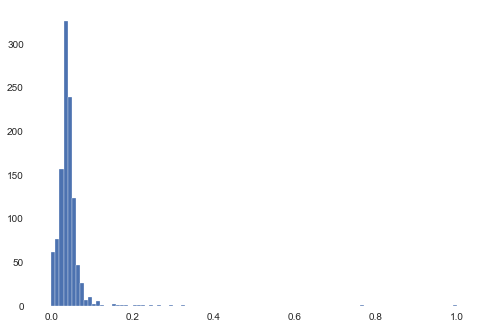

In [39]:
plt.hist(area_transformed_mm, bins=100);

In [40]:
np.percentile(area_transformed_mm, 95)

0.07366986842412768

- The values are supposed to be squished between 0 and 1, but actually 95% of the values are less that 0.075! 
- Question: Why would this be an issue?

<br><br><br><br><br><br>

Because some methods rely on different columns having the same "scale".

- A great comparison of scalers in the presence of outliers can be found [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).
- Here are a couple scalers they mention:

In [41]:
rb = RobustScaler()
area_transformed_rb = rb.fit_transform(housing_train[["LotArea"]])

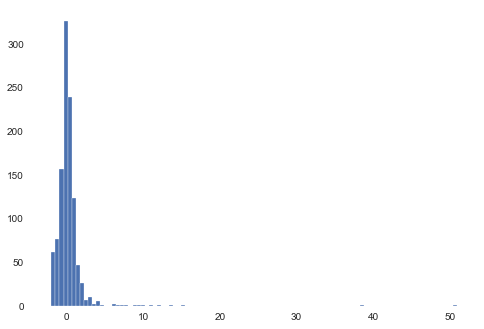

In [42]:
plt.hist(area_transformed_rb, bins=100);

In [43]:
qt = QuantileTransformer()
area_transformed_qt = qt.fit_transform(housing_train[["LotArea"]])

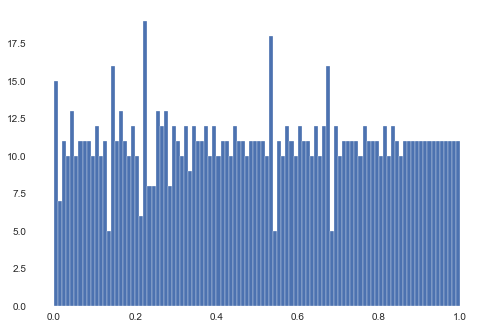

In [44]:
plt.hist(area_transformed_qt, bins=100);

- This transformer gives you a uniform distribution as its output. 
- It basically looks at the _order_ of the values, instead of the values themselves.
- Thus it doesn't care if your outlier is 1 million sq ft or 1 billion sq ft.

In [45]:
lot_area_crazy = housing_train[["LotArea"]].copy()
lot_area_crazy.iloc[0] = 999999999999999

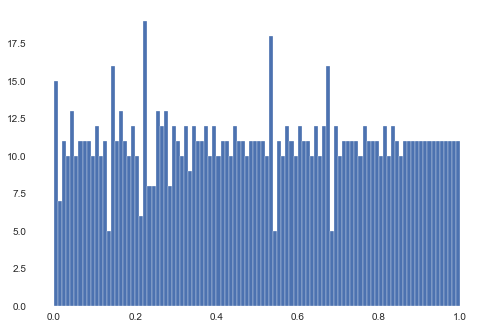

In [46]:
plt.hist(QuantileTransformer().fit_transform(lot_area_crazy), bins=100);

## Break (5 min)

<br>

REMINDER TO RESUME RECORDING

## Mean vs. medians (5 min)

I create a small list of numbers:

In [47]:
x = [1,2,3,4,5,6,7,8,99999]

Let's look at these summary statistics:

In [48]:
np.mean(x)

11115.0

In [49]:
np.median(x)

5.0

In [50]:
np.std(x)

31425.23964374284

In [51]:
np.percentile(x, 75) - np.percentile(x, 25)

4.0

What happens if we change the 9 to 99? Or 99999?

- Because of this effect we say the median is more robust than the mean.
- That is why, for imputation, I tended to choose the median value as "typical".

## Effect on trained models (15 min)

In [52]:
housing_df = pd.read_csv("data/housing.csv", index_col=0)

housing_train, housing_test = train_test_split(housing_df, random_state=123)

X_train = housing_train.drop(columns=['SalePrice'])
y_train = housing_train['SalePrice']

X_test = housing_test.drop(columns=['SalePrice'])
y_test = housing_test['SalePrice']

In [53]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [54]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [55]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [56]:
preprocessing.fit(X_train);

In [57]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [58]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)
X_test_enc = pd.DataFrame(preprocessing.transform(X_test), index=X_test.index, columns=new_columns)

X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleCondition_Normal,SaleCondition_Partial,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.28498,0.064219,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.28498,0.297501,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.28498,0.023451,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.28498,-1.038776,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.28498,-0.286837,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleCondition_Normal,SaleCondition_Partial,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.28498,0.064219,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.28498,0.297501,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.28498,0.023451,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.28498,-1.038776,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.28498,-0.286837,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [60]:
lr = Ridge(alpha=100)
lr.fit(X_train_enc, y_train);

In [61]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs.loc["LotArea"]

Coefficient    3003.005458
Name: LotArea, dtype: float64

In [62]:
X_train_enc["LotArea"].max()

21.401850034926778

In [63]:
ind = X_train_enc["LotArea"].argmax()
ind

163

How does our model predict on that property with huge `LotArea`?

In [64]:
lr.predict(X_train_enc)[ind]

318626.0367417464

In [65]:
y_train.iloc[ind]

375000

There are two issues to consider here:

1. How does the outlier in the _training_ data change the trained model (i.e. coefficients) - `fit()`
2. How does the outlier in the _test_ data affect predictions on that example - `predict()`

The 2nd issue only pertains to outliers in the features; not the target.


What happens if we make a big outlier in `LotArea`?

In [66]:
X_train_corrupted = X_train_enc.copy()
X_train_corrupted.loc[X_train_corrupted.index[0], "LotArea"] = 10_000 # 10_000 standard devs above mean

In [67]:
lr = Ridge(alpha=100)
lr.fit(X_train_corrupted, y_train);

Old coefs:

In [68]:
lr_coefs.head()

,Coefficient
LotFrontage,-1959.026983
LotArea,3003.005458
OverallQual,14490.849301
OverallCond,4840.226683
YearBuilt,1843.372943


New coefs:

In [69]:
lr_coefs_x_outlier = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs_x_outlier.head()

,Coefficient
LotFrontage,-1412.290991
LotArea,2.453697
OverallQual,14424.297875
OverallCond,4826.290991
YearBuilt,1755.999762


It was basically forced to ignore `LotArea` to avoid a humongous prediction for that one example.

What happens if we make a big outlier in the targets?

In [104]:
len(y_train)

1095

In [105]:
y_train_corrupted = y_train.copy().values
y_train_corrupted[0] = 1_000_000_000 # $1 billion

In [130]:
lr = Ridge(alpha=100)
lr.fit(X_train_enc, y_train_corrupted);

In [131]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])

In [132]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
PavedDrive_P,6.902202e+06
Neighborhood_Mitchel,6.597829e+06
BsmtFinType1_Rec,4.465575e+06
LotConfig_CulDSac,4.394171e+06
MoSold_4,4.171259e+06
...,...
Neighborhood_Sawyer,-1.507493e+06
MasVnrType_None,-1.823774e+06
Neighborhood_NAmes,-1.864995e+06
LotConfig_Inside,-2.470638e+06


In [141]:
lr.predict(X_train_enc)[800]

-141948.9047954036

Hmm, so this house is predicted to be worth -\$150,000...

In [144]:
y_train_corrupted[800]

314813

In [145]:
y_train.iloc[800]

314813

- This is _not_ the corrupted training example! 
- This crazy prediction is happening for a _different_ training example.

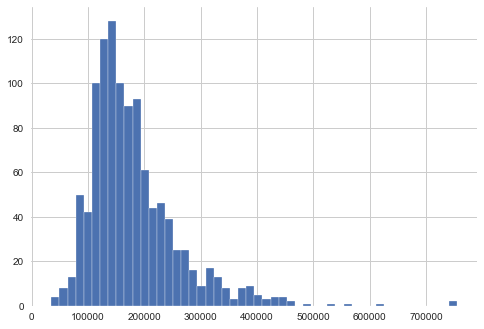

In [136]:
y_train.hist(bins=50);

In [137]:
train_predictions = lr.predict(X_train_enc)

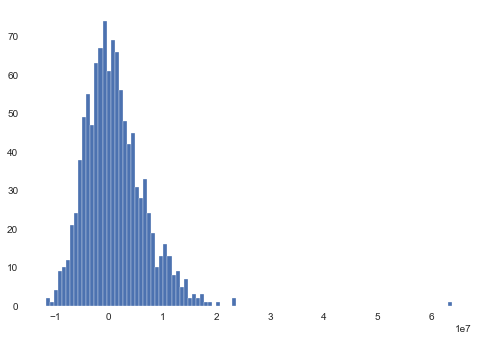

In [138]:
plt.hist(train_predictions, bins=100);

- Above: At the far right you can see the prediction for the corrupted training example

Yikes!! What if we're log-transforming our targets?

In [148]:
lr = TransformedTargetRegressor(Ridge(alpha=100), func=np.log1p, inverse_func=np.expm1)
lr.fit(X_train_enc, y_train_corrupted);

In [149]:
lr_coefs = pd.DataFrame(data=lr.regressor_.coef_, index=X_train_enc.columns, columns=["Coefficient"])

In [150]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
OverallQual,0.073587
PavedDrive_P,0.062752
OverallCond,0.055144
LotConfig_CulDSac,0.052169
Neighborhood_Mitchel,0.050506
...,...
LotConfig_Inside,-0.027992
MSZoning_C (all),-0.028830
BsmtFinType1_Unf,-0.029970
Neighborhood_Edwards,-0.030938


In [151]:
lr.predict(X_train_enc)[0]

234707.6586589173

- Here we're OK because the log-transforming made the $1B house not that bad. 

What about a random forest?

In [152]:
rf = RandomForestRegressor(max_depth=20, n_estimators=20)
rf.fit(X_train_enc, y_train_corrupted);

In [153]:
rf.predict(X_train_enc)[ind]

318867.5

In [154]:
y_train.iloc[ind]

375000

But what about the prediction on the corrupted point itself:

In [155]:
rf.predict(X_train_enc)[0]

550060431.25

In [156]:
y_train_corrupted[0]

1000000000

In [157]:
train_predictions = rf.predict(X_train_enc)

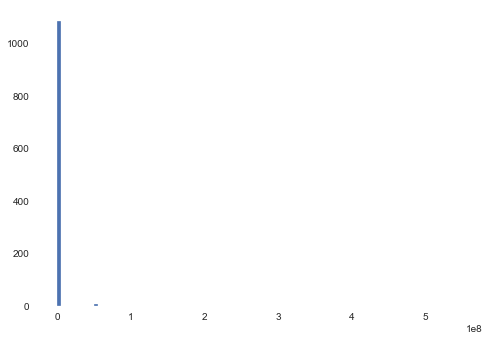

In [158]:
plt.hist(train_predictions, bins=100);

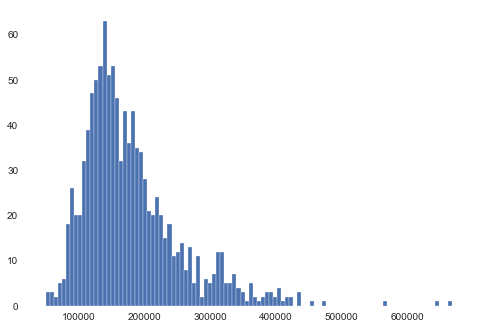

In [159]:
plt.hist(train_predictions[train_predictions < 1e6], bins=100);

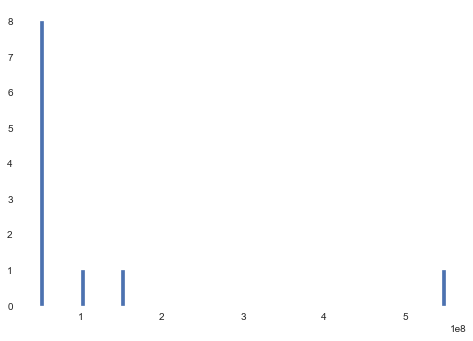

In [160]:
plt.hist(train_predictions[train_predictions > 1e6], bins=100);

- So, we get 10ish crazy predictions (presumably, cases with similar features to the corrupted data point). 
- We can compare this with a random forest trained on the original training data:

In [161]:
rf_uncorrupted = RandomForestRegressor(max_depth=20, n_estimators=20)
rf_uncorrupted.fit(X_train_enc, y_train);

In [162]:
train_predictions_unc = rf_uncorrupted.predict(X_train_enc)

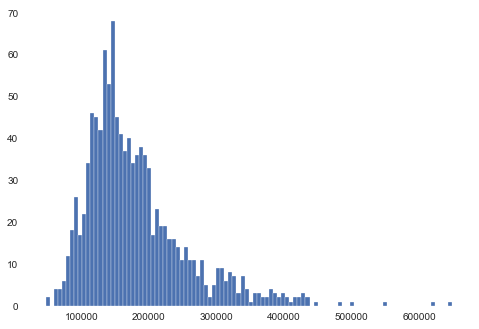

In [163]:
plt.hist(train_predictions_unc, bins=100);

## Robust linear regression (10 min)

- The linear regression suffered a lot more because the coefficients affect all predictions.
- There are ways around this, e.g. sklearn's [HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) is like Ridge but robust to outliers **in the targets**.
  - It even tells you the outliers afterward!
- Earlier I said always use `Ridge` over `LinearRegression`.
- So, always use `HuberRegressor` over `Ridge`?
  - As far as the model itself is concerned, yes. 
  - When there are no outliers, `HuberRegressor` will behave about the same as `Ridge.`
  - However, I wouldn't make as strong of a statement this time.
  - The reason is computational reasons - the way `fit()` works with `HuberRegressor` is different, and could be slower.
  - But sure, just to be a bit controversial, let me say always use `Ridge` over `LinearRegression` and always use `HuberRegressor` over `Ridge`.

In [96]:
from sklearn.linear_model import HuberRegressor

In [97]:
hr = HuberRegressor(max_iter=1000)
hr.fit(X_train_enc, y_train_corrupted);

In [98]:
hr_coefs = pd.DataFrame(data=hr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
hr_coefs.loc["LotArea"]

Coefficient    6204.200103
Name: LotArea, dtype: float64

In [99]:
hr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
Neighborhood_NridgHt,27842.108016
Neighborhood_StoneBr,23559.145673
Neighborhood_NoRidge,15908.385736
RoofMatl_Membran,14893.539054
GrLivArea,14869.210473
...,...
RoofMatl_ClyTile,-14868.968050
Heating_OthW,-14912.982134
MSZoning_C (all),-16001.785395
Neighborhood_Gilbert,-16540.179038


In [100]:
hr.predict(X_train_enc)[ind]

379861.62408116396

In [101]:
y_train_corrupted[ind]

375000

In [102]:
y_train.iloc[ind]

375000

## Supervised outlier detection (0 min)

#### Credit card fraud data (lecture 8)

In [164]:
df_credit = pd.read_csv('data/creditcard.csv', encoding='latin-1')
df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- We looked at this dataset for another reason, but this is really an anomaly detection problem!

## Outlier scenarios (5 min)

- Outliers are not always "bad".
- Remember when we talked about unbalanced training sets?
- We needed to ask ourselves two important questions:
  1. Are the deployment data and the training data coming from the same "distribution"?
  2. What types of mistakes are we most worried about?
   

#### House price example

Train vs. deploy? There are a few cases:

1. Train/deploy same distribution
  - the same software bug for recording `LotArea` will affect both train/test and deployment.
2. Outliers only in training data
  - the buggy software is only used to collect training data; or, the buggy software only affects our measurements of our target (house price)
3. Outliers only in deployment features
  - the training set is fine, but in deployment 

What do we care about? There are also cases:

1. We don't care about outliers (they are "mistakes" or we just don't care about predicting well on them)
  - software bug corrupted the `LotArea` for certain properties
  - we want to remove these
2. We want to predict correctly on outliers (they are "real data")
  - some properties genuinely have a huge `LotArea` and we want to predict well on such cases in deployment


#### This sounds like a huge mess, what should I do??
 
- Keep in mind that outliers are a tricky problem.
- Think carefully about how you want to treat outliers. 
- If they are "bad outliers"
  - Consider methods that are insensitive to outliers (e.g. Huber regression)
  - Consider explicitly finding and removing the outliers (e.g. via EDA)
- (Usually) Trust your validation/test scores, but not always!

## Summary (5 min)

- Outliers are everywhere
- Outliers are often undesireable, but not always!
- There are several ways of detecting outliers.
  - Visually
  - Clustering
  - Supervised learning (if labels are available)
  - Other approaches (see [CPSC 340 slides](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L10.pdf))
- Different summary statistics behave differently w.r.t. outliers
  - e.g. mean vs. median
- Different preprocessing methods behave differently w.r.t. outliers
  - e.g. `MinMaxScaler`
- Different models behave different w.r.t. outliers
  - e.g. `Ridge` vs. `HuberRegressor` or `RandomForestRegressor`
- One should carefully consider where the outliers might be occurring:
  - Train vs. deploy
  - X vs. y

## True/False questions

1. Outliers in the target values are not an issue for classification problems.
2. Outliers in the target values are not an issue in the deployment phrase.
3. Some outliers cannot be detected by looking at the individual feature histograms.
4. Consider the case of one big outlier in a feature vs. many rows with that unusually large/small value. `StandardScaler` behaves the same in both cases.
5. Consider the case of one big outlier in a feature vs. many rows with that unusually large/small value. `MinMaxScaler` behaves the same in both cases.